In [1]:
%%markdown
#### Supplementary Materials (Code) for
### "Minus-One" Data Prediction Generates Synthetic Census Data with Good Crosstabulation Fidelity

William H. Press<br>
[arXiv:2406.05264](https://arxiv.org/abs/2406.05264) [Submitted on 7 Jun 2024]

Run each cell sequentially, or execute Run All

#### Supplementary Materials (Code) for
### "Minus-One" Data Prediction Generates Synthetic Census Data with Good Crosstabulation Fidelity

William H. Press<br>
[arXiv:2406.05264](https://arxiv.org/abs/2406.05264) [Submitted on 7 Jun 2024]

Run each cell sequentially, or execute Run All


In [2]:
# This cell does imports and function defs only.
# always do this cell first

import pickle
import numpy as np
import socket
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical

def expand_df_to_binary_cols_torch(df):
    num_rows = df.shape[0]    
    expanded_matrix = torch.tensor([], dtype=torch.float, device=df.device)
    column_headers = []
    binary_columns_count = []    
    for col_idx in range(df.shape[1]):  # Iterate through columns by index
        col = df[:, col_idx]
        unique_values = torch.unique(col)        
        for value in unique_values:
            binary_matrix = (col[:, None] == value).float()
            expanded_matrix = torch.cat((expanded_matrix, binary_matrix), dim=1)
            column_headers.append(f"col_{col_idx}_{value.item()}")        
        binary_columns_count.append(len(unique_values))    
    return expanded_matrix, binary_columns_count, column_headers

class NonSelfPredictingLayer(nn.Module):
    def __init__(self, in_features, in_block_starts, out_features):
        super(NonSelfPredictingLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.in_block_starts = in_block_starts
        self.weight = nn.Parameter(torch.Tensor(self.in_features, self.out_features))
        self.bias = nn.Parameter(torch.Tensor(self.out_features))
        self.reset_parameters()
        self.weight.register_hook(self.gradient_hook)

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        bound = 1 / torch.sqrt(torch.tensor(self.out_features, dtype=torch.float))
        nn.init.uniform_(self.bias, -bound, bound)
        self.zero_blocks()

    def zero_blocks(self):
        with torch.no_grad():
            for start, end in zip(self.in_block_starts[:-1], self.in_block_starts[1:]):
                self.weight[start:end, start:end].fill_(0)

    def gradient_hook(self, grad):
        with torch.no_grad():
            for start, end in zip(self.in_block_starts[:-1], self.in_block_starts[1:]):
                grad[start:end, start:end] = 0
        return grad

    def forward(self, input):
        self.zero_blocks()
        output = torch.matmul(input, self.weight) + self.bias
        return torch.sigmoid(output)

def weighted_mse_loss(output, target, weights):
    loss = torch.mean(weights * (output - target) ** 2)
    return loss

def zval_loss_function(output, target, start_cols):
    crosstab_output = torch.matmul(output.T,output) + 0.01
    crosstab_target = torch.matmul(target.T,target) + 0.01
    Nt = target.shape[0]
    No = output.shape[0]
    Pt = crosstab_target / Nt
    Po = crosstab_output / No
    Pooled = (crosstab_target + crosstab_output) / (Nt + No)
    Var = Pooled * (1. - Pooled) * (1/Nt + 1/No)
    zsqvalues = (Pt - Po)**2 / (Var + 1.e-8) # or, start with 1.e-5 
    for start, end in zip(start_cols[:-1], start_cols[1:]):
        zsqvalues[start:end, start:end].fill_(0)
    loss = torch.mean(zsqvalues)    
    return loss

spyweights = []
class MultiBladeModel(nn.Module):
    def __init__(self, in_features, in_block_starts, out_features, reduced_features, num_blades):
        super(MultiBladeModel, self).__init__()
        self.in_features = in_features
        self.in_block_starts = in_block_starts
        self.out_features = out_features
        self.reduced_features = reduced_features
        self.num_blades = num_blades
        self.blades = nn.ModuleList([NonSelfPredictingLayer(in_features, in_block_starts, out_features) for _ in range(num_blades)])
        self.weight_calculator = WeightClassifier(in_features, reduced_features, num_blades)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        global spyweights
        outputs = [blade(x) for blade in self.blades]
        weights = self.weight_calculator(x)
        if type(spyweights) is list : spyweights.append(weights.detach().cpu())
        combined_output = torch.stack(outputs, dim=-1) * weights.unsqueeze(1)
        final_output = combined_output.sum(dim=-1)
        return final_output
    
class WeightClassifier(nn.Module):
    def __init__(self, in_features, reduced_features, num_outputs):
        super(WeightClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features, reduced_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(reduced_features, num_outputs)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        weights = torch.softmax(x, dim=1)
        return weights
    
class MultiBladeNumpy: # allows fiddling in numpy on an already trained model
    def __init__(self, model): # model is a MultiBladeModel on the GPU
        self.num_blades = model.num_blades
        self.bladelist = model.blades
        self.wgts = [blade.weight.detach().cpu().numpy() for blade in self.bladelist]
        self.offs = [blade.bias.detach().cpu().numpy() for blade in self.bladelist]
    def npsigmoid(self,x) :
        return 1./(1.+np.exp(-np.clip(x,-50.,50.)))
    def __call__(self, in_bin, spyweights):
        alloutputs = np.array([self.npsigmoid(in_bin @ ww + oo) for (ww,oo) in zip(self.wgts,self.offs)])
        outputs = np.einsum('ij,jik->ik',spyweights,alloutputs)
        return outputs

def save_model(filepath, model, optimizer, epoch, best_val_loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'config': {
            'in_features': model.in_features,
            'in_block_starts': model.in_block_starts,
            'out_features': model.out_features,
            'reduced_features': model.reduced_features,
            'num_blades': len(model.blades),
            'lr': optimizer.param_groups[0]['lr'],
            'best_val_loss': best_val_loss
        }
    }, filepath)
    
def load_model(filepath):
    checkpoint = torch.load(filepath)
    config = checkpoint['config']
    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    epoch = checkpoint['epoch']
    model = MultiBladeModel(
        in_features=config['in_features'],
        in_block_starts=config['in_block_starts'],
        out_features=config['out_features'],
        reduced_features=config['reduced_features'],
        num_blades=config['num_blades']
    )
    model.to(device)
    model.load_state_dict(model_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    optimizer.load_state_dict(optimizer_state_dict)
    best_val_loss = config['best_val_loss']
    return model, optimizer, epoch, best_val_loss

def setup_new_model(num_blades, reduced_features) : # wrapper for above
    global tot_cols, start_cols
    model = MultiBladeModel(tot_cols, start_cols, tot_cols, reduced_features, num_blades).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    epoch = 0
    return model, optimizer, epoch, best_val_loss, criterion

def load_old_model(path) :  # wrapper for above
    model, optimizer, epoch, best_val_loss = load_model(path)
    criterion = nn.MSELoss()
    return model, optimizer, epoch, best_val_loss, criterion

def summarizelogdiff(data1,data2,pseudocounts=1) :
    cross1 = torch.matmul(data1.T,data1) + pseudocounts
    cross2 = torch.matmul(data2.T,data2) + pseudocounts
    fmean = torch.mean(torch.abs(torch.log(cross1/cross2)))
    fstd = torch.std(torch.log(cross1/cross2))
    fmedian = torch.median(torch.abs(torch.log(cross1/cross2)))
    print(f'median log deviation, meanabs, rms, = {fmedian:.3f}, {fmean:.3f}, {fstd:.3f}')

def instantiate(probdat, trudat, start_cols, structzeros=None, pred_frac_arg=None) :
    powerfudge = 1. #0.85
    log2 = np.log(2.)
    pred_frac = (1. if pred_frac_arg is None else pred_frac_arg)
    instant = torch.zeros_like(probdat)
    entropies = torch.zeros(probdat.shape[0],device=device)
    for k in range(len(start_cols)-1) :
        qprobs = (pred_frac * (probdat[:,start_cols[k]:start_cols[k+1]])**powerfudge
                  + (1.-pred_frac) * (trudat[:,start_cols[k]:start_cols[k+1]]))
        qprobs /= torch.sum(qprobs,axis=1,keepdim=True)
        entropies -= torch.sum((qprobs + 1.e-10)*torch.log(qprobs + 1.e-10),axis=1) / log2
        # Create a categorical distribution and sample from it
        dist = Categorical(qprobs)
        samples = dist.sample()  # This will give indices according to the row probabilities
        instant[torch.arange(instant.shape[0]), samples + start_cols[k]] = 1        
    cutmask = torch.zeros(instant.shape[0],dtype=torch.bool,device=device)
    if structzeros is not None :
        counts = torch.zeros(instant.shape[0],device=device,dtype=torch.int)
        indices = torch.nonzero(structzeros) # indices of structural zeros
        for (i,j) in indices:
            products = instant[:, i] * instant[:, j]
            counts += products.ne(0)
        cutmask = torch.logical_or(cutmask, (counts > 0).bool())
    serials = torch.arange(instant.shape[0],device=device)
    return instant[~cutmask], entropies[~cutmask], serials[~cutmask]

print('done.')

done.


In [3]:
# This cell sets some environment stuff, reads the STUMS data, and sets a bunch of globals later used.
# always do this cell second

WHICHDATA = "STUMS" # "STUMS" (base case) or "STUMS-H" (for Supplementary Material in the paper)

np.set_printoptions(edgeitems=30, linewidth=100000)
dire = '/home/wpress/census_github/' # where to find the files
if torch.cuda.is_available() :
    device = torch.device("cuda")
    cudaname = torch.cuda.get_device_name()
    print(f"Using {device} device {cudaname}.")
else :
    raise SystemError("Can\'t find a GPU.")

def set_lots_of_global_stuff(WHICHDATA) :
    global infile, wtfile, STUMScols, df, weights, df_t, weights_t, df_bin, df_bin_t, col_counts
    global cols_dict, tot_cols, start_cols, multiplicity, crosstab_t, crosstab
    global in_bin_t, in_bin, out_start_cols, colnams, pretrained_models, structzeros
    print(f'Setting global data for {WHICHDATA}.')
    if WHICHDATA == "STUMS" :
        infile = "STUMS_df_all.pkl"
        wtfile = "STUMS_weights_df.pkl"
        STUMScols = ['SEX','AGEP','SCHL','RAC1P','ESR','MAR','DIS','PINCP','NATIVITY','MIL','ENG','HICOV','FER',
                    'JWMNP','WAOB','SCH','SCHG','PERNP','SSP','PAP','MSP','MARHT','MARHYP','MARHW','MARHM','MARHD',
                    'WRK','JWAP','WKHP','WKWN','CIT','DECADE','JWTRNS','LANX','LANP','DEYE','DEAR','DREM',]
        pretrained_models = {'1_1':'model_1_1.sav', '3_10':'model_3_10.sav', '5_15':'model_5_15.sav',
            '12_24':'model_12_24.sav'}
    elif WHICHDATA == "STUMS-H" :
        infile = "STUMS-H_df_all.pkl"
        wtfile = "STUMS-H_weights_df.pkl"
        STUMScols = ['NP','NPF','ACR','NR','YRBLT','TEN','VALP','RMSP','HFL','WATP','BLD', 'RNTP','GRNTP','MHP',
                     'MRGP','SMP','SMOCP','INSP','TAXAMT','PLM','BATH','BDSP','KIT','VEH','TEL','ACCESSINET',
                     'SMARTPHONE','LAPTOP','BROADBND','COMPOTHX','HISPEED','HINCP','FINCP','FS','ELEP','HHT',
                     'WIF','PARTNER','HUPAC','HUGCL','CPLT','HHLDRAGEP','HHLDRRAC1P','HHL','LNGI','FPARC',]
        pretrained_models = {'5_15':'model-h_5_15.sav'}
    df = pd.read_pickle(dire + infile)
    assert df.shape[1] == len(STUMScols)
    print("Dataframe shape:", df.shape)
    dfwgts = pd.read_pickle(dire + wtfile) # we don't use the weights, but here loaded for completeness
    weights = dfwgts.to_numpy().astype(float)
    print("Weights array shape:", weights.shape)
    assert(weights.shape[0] == df.shape[0]) # check compatible data and weights

    # move various to GPU. Note convention that _t means it is on GPU.
    df_t = torch.tensor(df.to_numpy(), dtype=torch.float32).detach().to(device)
    weights_t = torch.tensor(weights, dtype=torch.float32).detach().to(device)
    df_bin_t, col_counts, col_headers = expand_df_to_binary_cols_torch(df_t)
    df_bin = df_bin_t.detach().cpu().numpy()
    print("Binary data array shape:", df_bin.shape)

    # associate columns (number and starting index) with questions
    cols_dict = dict(zip(STUMScols, col_counts))
    col_counts = np.array([cols_dict[x] for x in STUMScols])
    tot_cols = np.sum(col_counts)
    start_cols = np.insert(np.cumsum(col_counts),0,0)
    print('Here are the questions and their numbers of categorical columns:')
    print(list(zip(STUMScols, col_counts)))

    # multiplicity of the rows in df_bin_t
    unique_rows, inverse_indices = torch.unique(df_bin_t, dim=0, return_inverse=True, return_counts=False)
    occurrences = torch.bincount(inverse_indices)
    multiplicity = occurrences[inverse_indices]

    # reference STUMS crosstabulation
    crosstab_t = torch.matmul(df_bin_t.T,df_bin_t)
    crosstab = crosstab_t.detach().cpu().numpy()
    structzeros = (crosstab_t == 0.)
    (in_bin_t, in_bin, out_start_cols, colnams) = (df_bin_t, df_bin, start_cols, STUMScols ) # some synonyms
    
# get the data
set_lots_of_global_stuff(WHICHDATA)
print('done.')

Using cuda device NVIDIA GeForce RTX 3090.
Setting global data for STUMS.
Dataframe shape: (292919, 38)
Weights array shape: (292919, 81)
Binary data array shape: (292919, 233)
Here are the questions and their numbers of categorical columns:
[('SEX', 2), ('AGEP', 11), ('SCHL', 10), ('RAC1P', 9), ('ESR', 7), ('MAR', 5), ('DIS', 2), ('PINCP', 10), ('NATIVITY', 2), ('MIL', 5), ('ENG', 5), ('HICOV', 2), ('FER', 3), ('JWMNP', 11), ('WAOB', 8), ('SCH', 4), ('SCHG', 6), ('PERNP', 10), ('SSP', 12), ('PAP', 12), ('MSP', 7), ('MARHT', 4), ('MARHYP', 9), ('MARHW', 3), ('MARHM', 3), ('MARHD', 3), ('WRK', 3), ('JWAP', 11), ('WKHP', 11), ('WKWN', 7), ('CIT', 5), ('DECADE', 9), ('JWTRNS', 8), ('LANX', 3), ('LANP', 4), ('DEYE', 2), ('DEAR', 2), ('DREM', 3)]
done.


In [4]:
# Create a new model or load a pretrained one (supplied files)
MODEL_NEW_OR_OLD = "OLD"
if MODEL_NEW_OR_OLD == "OLD" :
    in_model_path = dire + pretrained_models["5_15"] # <--pick one of the above pretrained models
    model, optimizer, epoch, best_val_loss, criterion = load_old_model(in_model_path)
    print(f'Pre-trained model loaded from {in_model_path}.')
    assert ((WHICHDATA == "STUMS-H" and model.in_features == 315) # check that model and data match
            or (WHICHDATA == "STUMS" and model.in_features == 233))
elif MODEL_NEW_OR_OLD == "NEW" :
    model, optimizer, epoch, best_val_loss, criterion = setup_new_model(5,10) # <-- set parameters
    print('New model loaded for training.')
else :
    assert ValueError("bad MODEL_NEW_OR_OLD")
out_model_path = dire + 'model_foo.sav' # where to save if you do more training
print(f"Model has {model.num_blades} blades and {model.reduced_features} reduced features.")
print('done.')

Pre-trained model loaded from /home/wpress/census_github/model_5_15.sav.
Model has 5 blades and 15 reduced features.
done.


In [5]:
# plotting function for Figures 1, 2, 4, 5, 6a, 6b

def plot_uni_and_crosstab(in_bin_t, synthetic_t, pseudocounts, aword="synthetic") :
    fig, plt1 = plt.subplots(figsize=(10, 10))  # Single subplot
    plt2 = inset_axes(plt1, width="38%", height="38%", loc='lower right', borderpad=3)
    Nrow = in_bin_t.shape[0]
    trucrosstab = torch.matmul(in_bin_t.T,in_bin_t).cpu().numpy() + pseudocounts
    nrow = synthetic_t.shape[0]
    thecrosstab = torch.matmul(synthetic_t.T,synthetic_t).detach().cpu().numpy() + pseudocounts
    fmean = np.mean(np.abs(np.log(trucrosstab/thecrosstab)))
    fstd = np.std(np.log(trucrosstab/thecrosstab))
    fmedian = np.median(np.abs(np.log(trucrosstab/thecrosstab)))
    print(f'log deviations: median={fmedian:.3f}, meanabs={fmean:.3f}, rms={fstd:.3f}')    
    xx = (trucrosstab.flatten()/Nrow + 1.e-10)
    yy = (thecrosstab.flatten()/nrow + 1.e-10)
    plt1.scatter(xx,yy,s=0.3,color='darkblue')
    plt1.set_xlabel('true probability',size=15.)
    plt1.set_ylabel(f'{aword} probability',size=15.)
    plt1.text(5.e-6,0.2,f"crosstab probabilities\ntrue vs. {aword}",size=20.)
    plt1.set_xlim((1.e-6,1))
    plt1.set_ylim((1.e-6,1))
    plt1.tick_params(axis='both', which='major', labelsize=14)
    plt1.set_xscale('log')
    plt1.set_yscale('log')
    insums = torch.mean(in_bin_t,axis=0).detach().cpu().numpy()
    outsums = torch.mean(synthetic_t,axis=0).detach().cpu().numpy()
    plt2.scatter(insums,outsums,s=2.,color='red')
    plt2.set_ylabel(aword,size=10.)
    plt2.text(7.e-4,0.2,f"univariate probabilities\ntrue vs. {aword}",size=13.)
    plt2.set_xlim((5.e-4,1))
    plt2.set_ylim((5.e-4,1))
    plt2.tick_params(axis='both', which='major', labelsize=10)
    plt2.set_xscale('log')
    plt2.set_yscale('log')
    plt.show()

def plot_uni_and_crosstab_counts(in_bin_t, synthetic_t, pseudocounts, aword="synthetic") :
    fig, plt1 = plt.subplots(figsize=(10, 10))  # Single subplot
    plt2 = inset_axes(plt1, width="38%", height="38%", loc='lower right', borderpad=3)
    Nrow = in_bin_t.shape[0]
    trucrosstab = torch.matmul(in_bin_t.T,in_bin_t).cpu().numpy() + pseudocounts
    nrow = synthetic_t.shape[0]
    thecrosstab = torch.matmul(synthetic_t.T,synthetic_t).detach().cpu().numpy() + pseudocounts
    fmean = np.mean(np.abs(np.log(trucrosstab/thecrosstab)))
    fstd = np.std(np.log(trucrosstab/thecrosstab))
    fmedian = np.median(np.abs(np.log(trucrosstab/thecrosstab)))
    print(f'log deviations: median={fmedian:.3f}, meanabs={fmean:.3f}, rms={fstd:.3f}')    
    xx = (trucrosstab.flatten() + 1.e-10 * Nrow)
    yy = (thecrosstab.flatten() + 1.e-10 * nrow)
    plt1.scatter(xx,yy,s=0.3,color='darkblue')
    plt1.set_xlabel('true counts',size=15.)
    plt1.set_ylabel(f'{aword} counts',size=15.)
    plt1.text(1.,1.e5,f"crosstab counts\ntrue vs. {aword}",size=20.)
    plt1.set_xlim((0.8,3e5))
    plt1.set_ylim((0.8,3e5))
    plt1.tick_params(axis='both', which='major', labelsize=14)
    plt1.set_xscale('log')
    plt1.set_yscale('log')
    insums = torch.sum(in_bin_t,axis=0).detach().cpu().numpy()
    outsums = torch.sum(synthetic_t,axis=0).detach().cpu().numpy()
    plt2.scatter(insums,outsums,s=2.,color='red')
    plt2.set_ylabel(aword,size=10.)
    plt2.text(15,5.e4,f"univariate counts\ntrue vs. {aword}",size=13.)
    plt2.set_xlim((10,3.3e5))
    plt2.set_ylim((10,3.3e5))
    plt2.tick_params(axis='both', which='major', labelsize=10)
    plt2.set_xscale('log')
    plt2.set_yscale('log')
    plt.show()
print('done.')

done.


log deviations: median=0.048, meanabs=0.133, rms=0.253


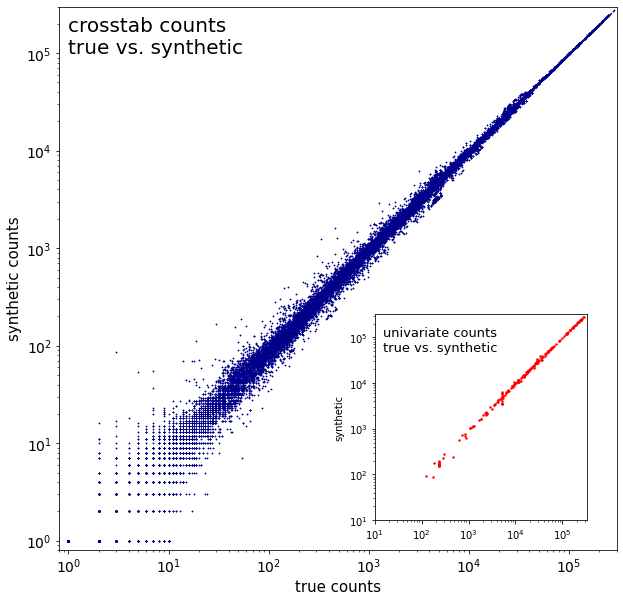

In [6]:
# make Figures 1, 2, 4, 5, 6a, 6b

try : # did we already set globals?
    in_bin_t
except : # if not, do it now
    WHICHDATA = "STUMS-H"
    set_lots_of_global_stuff(WHICHDATA)

FIGURE = "5" # pick one of 1, 2, 4, 5, 6a, or 6b

pseudocounts = 1.
figargs = {"2":('1_1', None, None), "4":('5_15', None, None), "5":('5_15', structzeros, None),
        "6a":('5_15', None, 0.6666), "6b":('5_15', None, 0.5)}

if FIGURE == "1" :
    indices = torch.randint(0, in_bin_t.shape[0], (in_bin_t.shape[0],))
    synthetic_t = in_bin_t[indices]
else :
    name, arg1, arg2 = figargs[FIGURE]
    if WHICHDATA == "STUMS-H" and FIGURE == '2' : raise ValueError("no Figure 2 for STUMS-H")
    in_model_path = dire + pretrained_models[name]
    model, _, _, _, _ = load_old_model(in_model_path)
    model.eval()
    probdat_t = model(in_bin_t) + pseudocounts/in_bin_t.shape[0] 
    synthetic_t, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols, arg1, arg2)

plot_uni_and_crosstab_counts(in_bin_t, synthetic_t, pseudocounts)

rarity min max 9.0 283641.0
Model has 3 blades and 10 reduced features,
and will be saved to /home/wpress/census_github/mymodel_foo.sav.
saved model with 0.248059 to /home/wpress/census_github/mymodel_foo.sav
changing stages
log deviations: median=0.121, meanabs=0.853, rms=1.774


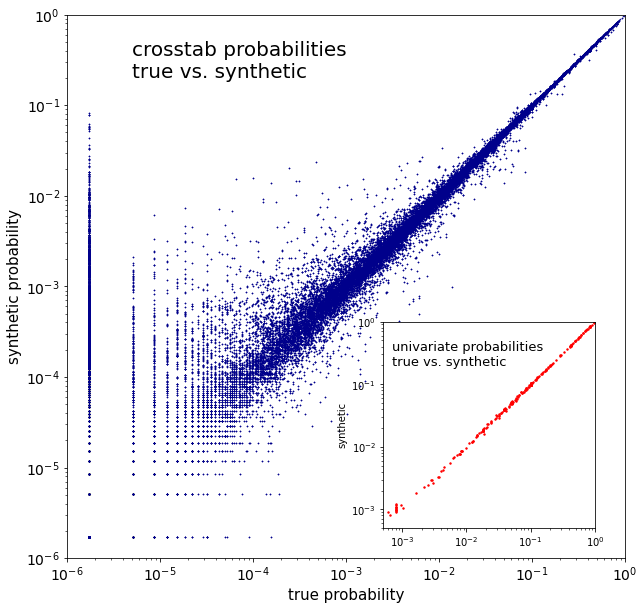

done.
CPU times: user 48.2 s, sys: 1.24 s, total: 49.5 s
Wall time: 48.9 s


In [7]:
%%time
# Training! Here is an example of creating a new 3-blade model, training it for a while
# with weighted MSE loss, then switching to z-val loss and training some more.
# This is not necessarily trained to completion but is only an illustration of the procedure.

# define weights for the weighted MSE (this is art, not science!)
add_counts = 10 # can play with this parameter
mult_specials_by = 10. # can play with this parameter
rarity_t = torch.sum(in_bin_t, axis=0)
print('rarity min max',torch.min(rarity_t).item(),torch.max(rarity_t).item())
loss_weights = 1./torch.sqrt(rarity_t + add_counts)
specials = [ 25, 169, 178,  31,  21, 182,  183, 27, 170, 213, 108,   6,   1,  23,  15, 210,  49, 116, 115, 209,  20]
loss_weights[torch.tensor(specials,dtype=torch.long)] *= mult_specials_by
loss_weights = loss_weights / torch.mean(loss_weights)

# DataLoader is slow compared with fitting all the data onto the GPU.
USE_DATA_LOADER = False
if USE_DATA_LOADER :
    dataset = TensorDataset(in_bin_t,in_bin_t) # inputs and targets are the same
    batch_size = 10000
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else :
    data_loader = ((in_bin_t, in_bin_t),) # inputs and targets are the same

# define an empty model
model, optimizer, epoch, best_val_loss, _ = setup_new_model(3,10)
print(f"Model has {model.num_blades} blades and {model.reduced_features} reduced features,")
out_model_path = dire + "mymodel_foo.sav" # where to save trained model
print(f"and will be saved to {out_model_path}.")
model.train()
spyweights = None # will use later but not now
oldtime = time.perf_counter()
shosav = True

# train it
num_epochs = 1000 # 10000 is a good value (takes 8 min on my machine)
stage = 0
for epoch in range(num_epochs):
    for batch in data_loader :
        inputs = batch[0]
        targets = batch[1]
        optimizer.zero_grad()
        outputs = model(inputs)
        if stage == 0 :
            loss = weighted_mse_loss(outputs, targets, loss_weights)
        else :
            loss = zval_loss_function(outputs, targets, model.in_block_starts )
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for blade in model.blades:  # Iterate over all blades
                for start, end in zip(blade.in_block_starts, blade.in_block_starts[1:]):
                    blade.weight[start:end, start:end] = 0
    newtime = time.perf_counter()
    if loss.item() < best_val_loss :
        best_val_loss = loss.item()
        save_model(out_model_path, model, optimizer, epoch, best_val_loss)
        if shosav: print(f'saved model with {best_val_loss:.6f} to {out_model_path}')
        shosav = False
    if (newtime-oldtime) > 60. : # print message only every 1 minute
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')
        oldtime = newtime
        shosav = True
    if epoch == num_epochs // 2 :
        print('changing stages')
        stage = 1
        optimizer = optim.Adam(model.parameters(), lr=0.001) # reset optimizer
        best_val_loss = float('inf')

# plot the result after this much training
model.eval()
probdat_t = model(in_bin_t) + 0.5/in_bin_t.shape[0] # half a pseudo-count
synthetic_t, _, _= instantiate(probdat_t, in_bin_t, start_cols)
plot_uni_and_crosstab(in_bin_t, synthetic_t, 0.5)        
        
print('done.')

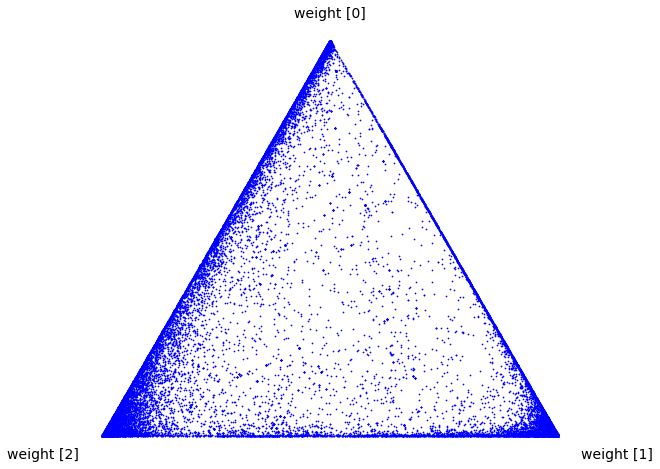

In [8]:
# make Figure 3
if WHICHDATA != "STUMS" :
    print("Figure 3 is for STUMS only.")
else :
    def create_triangular_plot(data):
        corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
        triangulation = tri.Triangulation(corners[:, 0], corners[:, 1], [[0, 1, 2]])
        refiner = tri.UniformTriRefiner(triangulation)
        trimesh = refiner.refine_triangulation(subdiv=4)
        pvals = np.dot(data, corners)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot()
        ax.set_aspect('equal')
        plt.triplot(triangulation, lw=0.5, color='gray')
        plt.scatter(pvals[:, 0], pvals[:, 1], c='b', s=0.5, zorder=3)
        plt.axis('off')
        plt.grid(False)
        plt.text(-0.05, -0.05, 'weight [2]', horizontalalignment='right',size=14)
        plt.text(1.05, -0.05, 'weight [1]', horizontalalignment='left',size=14)
        plt.text(0.5, np.sqrt(3)/2 + 0.05, 'weight [0]', horizontalalignment='center',size=14)
        plt.savefig(dire+"triangleplot.pdf", format='pdf', dpi=1200)
        plt.show()

    in_model_path = dire + 'model_3_10.sav'
    model, _, _, _, _ = load_old_model(in_model_path)
    model.eval()
    spyweights = []
    probdat_t = model(in_bin_t) + 0.5/in_bin_t.shape[0] # half a pseudo-count
    create_triangular_plot(spyweights[0][::10])


meanabs, rms, median log deviation= 0.136, 0.356, 0.029
meanabs, rms, median log deviation= 0.119, 0.323, 0.024


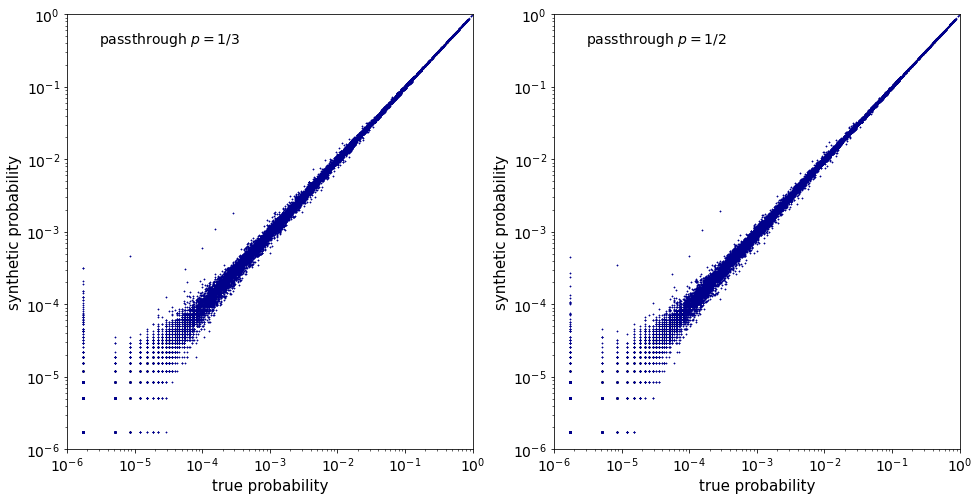

done.


In [9]:
# make Figure 6a and 6b together
# (make Figure 5 first, above)
fig, (plt1,plt2) = plt.subplots(1, 2, figsize=(16, 8))

in_model_path = dire + pretrained_models["5_15"] # <--pick one of the above pretrained models
model, optimizer, epoch, best_val_loss, criterion = load_old_model(in_model_path)
probdat_t = model(in_bin_t) + 1.0/in_bin_t.shape[0]
synthetic_t, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols, None, None )
synthetic_t1, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols, None, 0.6666 )
synthetic_t2, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols, None, 0.5 )
Nrow = in_bin_t.shape[0]
trucrosstab = crosstab + 0.5
xx = (trucrosstab.flatten()/Nrow + 1.e-10)

plts = [plt1,plt2]
instants = [synthetic_t1,synthetic_t2]
labels = ["passthrough $p=1/3$","passthrough $p=1/2$"]

for i in range(2) :
    nrow = instants[i].shape[0]
    thecrosstab = torch.matmul(instants[i].T,instants[i]).detach().cpu().numpy() + 0.5
    
    fmean = np.mean(np.abs(np.log(trucrosstab/thecrosstab)))
    fstd = np.std(np.log(trucrosstab/thecrosstab))
    fmedian = np.median(np.abs(np.log(trucrosstab/thecrosstab)))
    print(f'meanabs, rms, median log deviation= {fmean:.3f}, {fstd:.3f}, {fmedian:.3f}')

    yy = (thecrosstab.flatten()/nrow + 1.e-10)
    plts[i].scatter(xx,yy,s=0.3,color='darkblue')
    plts[i].set_xlabel('true probability',size=15.)
    plts[i].set_ylabel('synthetic probability',size=15.)
    plts[i].text(3.e-6,0.4,labels[i],size=14.)
    plts[i].set_xlim((1.e-6,1))
    plts[i].set_ylim((1.e-6,1))
    plts[i].tick_params(axis='both', which='major', labelsize=14)
    plts[i].set_xscale('log')
    plts[i].set_yscale('log')

plt.show()
print('done.')

log deviations: median=0.037, meanabs=0.145, rms=0.355


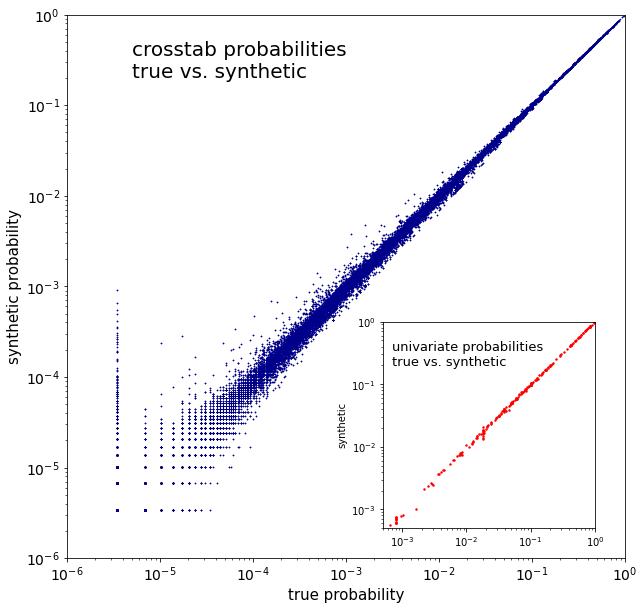

In [10]:
# demonstrate one strategy of Post-Processing (paper section 4.4)
pseudocounts = 1
in_model_path = dire + pretrained_models["5_15"]
model, optimizer, epoch, best_val_loss, criterion = load_old_model(in_model_path)
probdat_t = model(in_bin_t) + 1.0/in_bin_t.shape[0]
synthetic_t, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols)
synthetic_t2, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols)
syncross_t = torch.matmul(synthetic_t.T,synthetic_t)
poslogdiscrep = torch.max(torch.log((syncross_t+pseudocounts)/(crosstab_t+pseudocounts)),
        torch.tensor([0.,],device=device))

def manyrowscoresbatched(rows,crossprobwt_t): # batch in GPU to avoid exceeding memory
    nbatch = 10000
    num_rows = rows.shape[0]
    scores = torch.zeros(num_rows, dtype=torch.float, device=rows.device)
    for i in range(0, num_rows, nbatch):
        batch = rows[i:i+nbatch]
        batch_scores = torch.sum(batch[:, None, :] * batch[:, :, None] * crossprobwt_t, axis=(1, 2))
        scores[i:i+nbatch] = batch_scores
    return scores

scores = manyrowscoresbatched(synthetic_t,poslogdiscrep)
medscore = torch.median(scores)
condition = (torch.abs(scores) < medscore)
prunepost_t = torch.where(condition[:,None],synthetic_t,synthetic_t2)
plot_uni_and_crosstab(in_bin_t, prunepost_t, pseudocounts)        


medians: zval 0.76, lnval 0.05


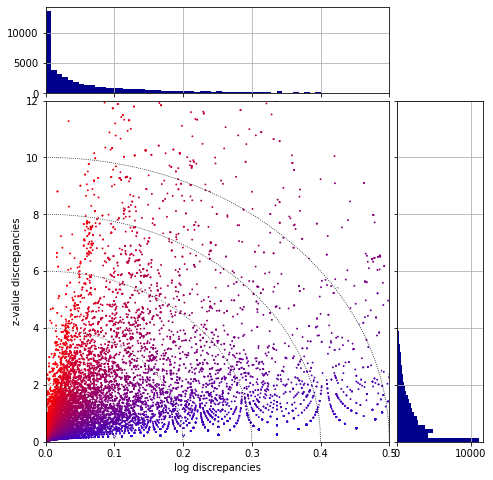

In [11]:
# make Figure 7

fig, axScatter = plt.subplots(figsize=(9, 8))
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)
fig.subplots_adjust(right=0.8)

dil = 3 # dilation factor to reduce density of dots
synthetic = synthetic_t # or try synthetic_tt, or _t1 or _t2 (see above)
Nrow = in_bin_t.shape[0]
nrow = synthetic.shape[0]
pseudocounts = 0.5
trucrosstab = crosstab + pseudocounts
thecrosstab = torch.matmul(synthetic.T,synthetic).detach().cpu().numpy() + pseudocounts
ptru = trucrosstab / Nrow
psyn = thecrosstab / nrow
ppool = (trucrosstab + thecrosstab) / (Nrow + nrow)
var = ppool * (1.-ppool) * (1/Nrow + 1/nrow)
zzvals = np.sqrt((ptru - psyn)**2 / (var + 1.e-10)).flatten()
lnvals = np.abs(np.log(ptru/psyn)).flatten()
print(f'medians: zval {np.median(zzvals):.2f}, lnval {np.median(lnvals):.2f}')
pcts = np.argsort(np.argsort(crosstab.flatten())) / float(len(crosstab.flatten()) - 1)
colorlist = [(x,0.,1.-x) for x in pcts]
colorlist = np.array(colorlist)

# the main plot
mask = np.random.choice(len(lnvals),size=len(lnvals)//dil)
axScatter.scatter(lnvals[mask],zzvals[mask],s=0.8,color=colorlist[mask])

# the side histograms
xwidth = 0.008
ywidth = 0.15
xbins = np.arange(0., 5. + xwidth, xwidth)
ybins = np.arange(0., 30. + ywidth, ywidth)
axHistx.hist(lnvals, bins=xbins,color="darkblue")
axHisty.hist(zzvals, bins=ybins, orientation='horizontal',color="darkblue")

axScatter.set_xlabel("log discrepancies")
axScatter.set_ylabel("z-value discrepancies")
axScatter.set_xlim((0.,0.5))
axScatter.set_ylim((0.,12.))
axHistx.tick_params(axis="x", labelbottom=False)
axHisty.tick_params(axis="y", labelleft=False)
axHistx.grid()
axHisty.grid()

# plot the curves of blended figure of merit
xcirc = np.linspace(0.,1.,500)
ycirc = np.sqrt(1.-xcirc**2)
for scale in np.arange(1,6) :
    axScatter.plot(0.1*scale*xcirc,2.*scale*ycirc,":",lw=0.8,color="black")
    axScatter.plot(0.1*1.005*scale*xcirc,2.*1.005*scale*ycirc,":",lw=1.6,color="white")

plt.show()

max,min of data plotted: 12.417883151470836 9.090909090909092e-31
totcols= 233


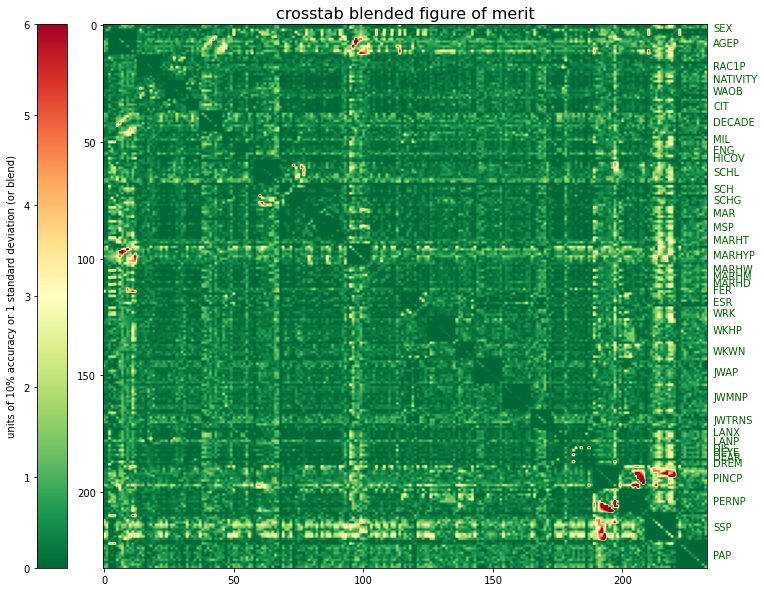

In [12]:
# make Figure 9
if WHICHDATA != "STUMS" :
    print("Figure 9 is now set up for STUMS only.")
else :
    def calculate_z_values(m1,m2,N1,N2):
        p1 = (m1) / (N1)  # proportions for m1
        p2 = (m2) / (N2)  # proportions for m2
        pooled_p = (m1 + m2) / (N1 + N2)
        SE = np.sqrt(pooled_p * (1 - pooled_p) * (1/(N1) + 1/(N2)))
        z_values = (p1 - p2) / (SE + 1.e-6)
        return z_values

    def calculate_log_diffs(m1,m2,N1,N2) :
        mm1 = m1
        mm2 = (m2*N1/N2)
        return np.log(mm1/mm2)

    def calculate_blended(m1,m2,N1,N2,fmz0=1.0,fmlog0=0.10) : # in units of 10% accuracy or 1 std dev
        fmlog = np.abs(calculate_log_diffs(m1,m2,N1,N2)) + 1.e-30
        fmz = np.abs(calculate_z_values(m1,m2,N1,N2)) + 1.e-30
        fmblend = 1./(fmlog0/fmlog + fmz0/fmz  + 1.e-30) 
        return fmblend    

    in_model_path = dire + pretrained_models["5_15"]
    model, optimizer, epoch, best_val_loss, criterion = load_old_model(in_model_path)
    probdat_t = model(in_bin_t) + 1.0/in_bin_t.shape[0]
    synthetic_t, _, _ = instantiate(probdat_t, in_bin_t, out_start_cols, None, None )

    mysynthetic = synthetic_t
    pseudocounts = 1.
    nrow = synthetic.shape[0]
    Nrow = in_bin_t.shape[0]
    ncols = col_counts
    thecrosstab = torch.matmul(mysynthetic.T,mysynthetic).cpu().numpy() + pseudocounts
    trucrosstab = torch.matmul(in_bin_t.T,in_bin_t).cpu().numpy() + pseudocounts
    plotdata = calculate_blended(thecrosstab,trucrosstab,nrow,Nrow)
    print('max,min of data plotted:',np.max(plotdata),np.min(plotdata))
    caption = 'crosstab blended figure of merit'
    (vmin,vmax) = (0,6)
    cmap = "RdYlGn_r"
    thestart_cols = start_cols # unless reordered below
    thecolnams = colnams # unless reordered below
    REORDER = True # re-order the questions into a more logical order (grouping schooling, marriage, etc.)
    if REORDER :
        thecolnams = ['SEX','AGEP','RAC1P','NATIVITY','WAOB','CIT','DECADE','MIL','ENG','HICOV',
                'SCHL','SCH','SCHG','MAR','MSP','MARHT','MARHYP','MARHW','MARHM','MARHD','FER',
                'ESR','WRK','WKHP','WKWN','JWAP','JWMNP','JWTRNS','LANX','LANP','DIS','DEYE','DEAR','DREM',
                'PINCP','PERNP','SSP','PAP',]
        colperm = [STUMScols.index(x) for x in thecolnams]
        newplotdata = np.zeros_like(plotdata)
        new_indices = []
        for idx in colperm:
            start_idx = start_cols[idx]
            end_idx = start_cols[idx + 1]
            new_indices.extend(list(range(start_idx, end_idx)))
        plotdata = plotdata[np.ix_(new_indices, new_indices)]    
        newncols = [ncols[i] for i in colperm]
        thestart_cols = [0]
        for length in newncols:
            thestart_cols.append(thestart_cols[-1] + length)
        tosum = []
        for nam in thecolnams :
            tosum.append(cols_dict[nam])
        print('totcols=',np.sum(tosum))

    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    cax = ax.imshow(plotdata, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("left", size="5%", pad=0.5)
    cbar = plt.colorbar(cax, cax=cbar_ax)
    cbar.set_ticks(np.arange(vmin, vmax + 1))
    cbar_ax.yaxis.set_ticks_position('left')
    cbar.set_label('units of 10% accuracy or 1 standard deviation (or blend)', rotation=90, labelpad=-60)
    # Annotate on the right
    for k in range(len(ncols)):
        nam = thecolnams[k]
        y = 0.5 * (thestart_cols[k] + thestart_cols[k+1])
        ax.text(235., y, nam, ha='left', va='center', color='darkgreen')
    # Set title and show plot
    ax.set_title(caption,fontsize=16)
    plt.show()

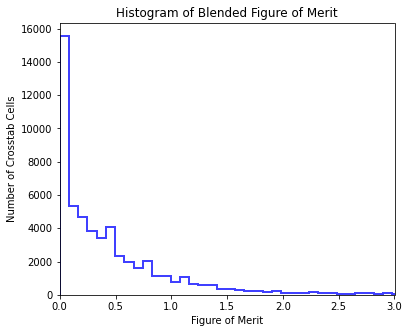

In [13]:
# make Figure 8
# (make Figure 9 first, above)
if WHICHDATA != "STUMS" :
    print("Figure 8 is now set up for STUMS only.")
else :
    flat_data = plotdata.flatten() # above set to the z-values or the log-values
    plt.figure(figsize=(6, 5))
    plt.hist(flat_data, bins=150, alpha=0.75, color='blue', histtype='step', lw=2.)
    plt.title('Histogram of Blended Figure of Merit')
    plt.xlabel('Figure of Merit')
    plt.ylabel('Number of Crosstab Cells')
    plt.xlim((0,3))
    plt.show()

(292919, 5)


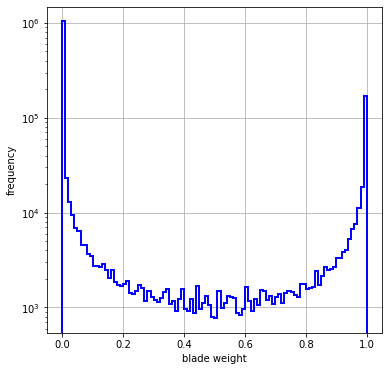

In [14]:
# make Figure 10
if WHICHDATA != "STUMS" :
    print("Figure 10 is now set up for STUMS only.")
else :
    in_model_path = dire + 'model_5_15.sav'
    model, _, _, _, _ = load_old_model(in_model_path)
    model.eval()
    spyweights = []
    probdat_t = model(in_bin_t)
    spyweights = spyweights[0].numpy()
    print(spyweights.shape)

    plt.figure(figsize=(6, 6))
    plt.hist(spyweights.flatten(), bins=100, alpha=0.99, lw=2., color='blue', histtype='step') # spyweights.flatten()
    plt.xlabel('blade weight')
    plt.ylabel('frequency')
    plt.grid(True)
    plt.yscale('log')
    plt.show()

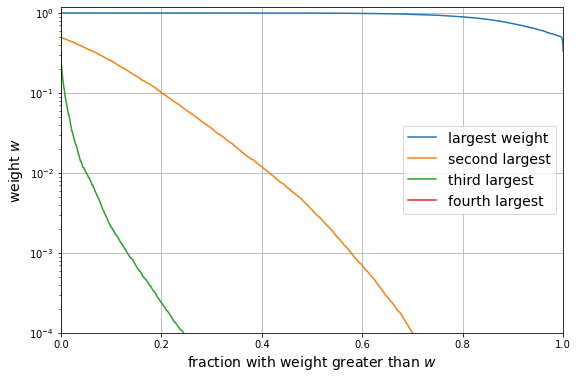

In [15]:
# make Figure 11
# (make Figure 10 first)
if WHICHDATA != "STUMS" :
    print("Figure 11 is now set up for STUMS only.")
else :
    plt.figure(figsize=(9, 6))
    sums = np.sum(spyweights, axis=1)
    myweights = spyweights / sums[:,None]
    colsorted = np.sort(myweights, axis=1)[:, ::-1]
    wsorted = np.sort(colsorted, axis=0)[::-1, :]
    leggs = ["largest weight","second largest","third largest","fourth largest"]
    for k in (0,1,2,3) :
        xx = np.arange(wsorted.shape[0])/wsorted.shape[0]
        yy = wsorted[:,k] + 1.e-10
        plt.semilogy(xx,yy,label=leggs[k])
    plt.grid()
    plt.ylim(1.e-4,1.2)
    plt.xlim(0,1)
    plt.ylabel("weight $w$",size=14)
    plt.xlabel("fraction with weight greater than $w$",size=14)
    plt.legend(fontsize=14)
    plt.show()

(292919,)


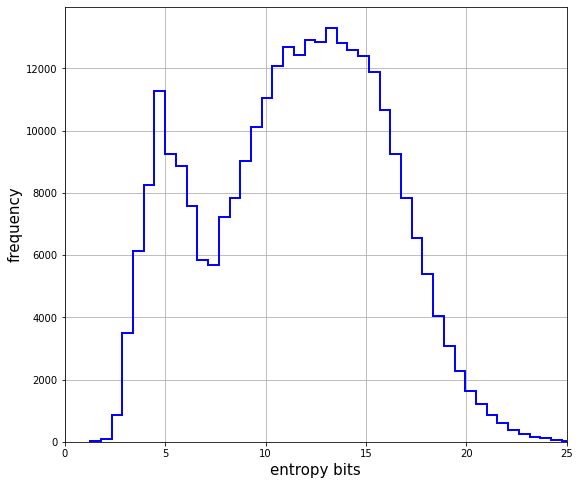

In [16]:
# make Figure 13
if WHICHDATA != "STUMS" :
    print("Figure 13 is now set up for STUMS only.")
else :
    plt.figure(figsize=(9, 8))
    in_model_path = dire + 'model_5_15.sav'
    model, _, _, _, _ = load_old_model(in_model_path)
    model.eval()
    probdat_t = model(in_bin_t)
    synthetic_t, entropies_t, _= instantiate(probdat_t, in_bin_t, start_cols)
    entropies = entropies_t.detach().cpu().numpy()
    print(entropies.shape)
    plt.hist(entropies, bins=50, alpha=0.99, lw=2., color='blue', histtype='step')
    plt.xlabel('entropy bits', size=15)
    plt.ylabel('frequency', size=15)
    plt.grid(True)
    plt.xlim((0,25))
    plt.show()
    del model # hint it should release memory
    torch.cuda.empty_cache() 

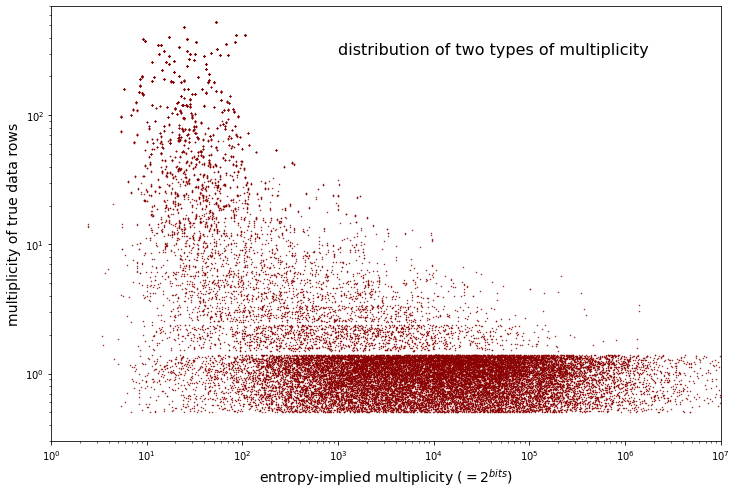

In [17]:
# make Figure 14
if WHICHDATA != "STUMS" :
    print("Figure 14 is now set up for STUMS only.")
else :
    plt.figure(figsize=(12, 8))
    in_model_path = dire + 'model_5_15.sav'
    model, _, _, _, _ = load_old_model(in_model_path)
    model.eval()
    probdat_t = model(in_bin_t)
    synthetic_t, entropies_t, serials = instantiate(probdat_t, in_bin_t, start_cols)
    xx = 2.**entropies_t.detach().cpu().numpy()[::10]
    yy = multiplicity[serials].detach().cpu().numpy().astype(float)
    yy += (- 0.5 + 0.9 * np.random.rand(len(yy)))
    yy = yy[::10]
    plt.scatter(xx,yy,s=0.2,color="darkred")
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel("entropy-implied multiplicity ($=2^{bits}$)",size=14)
    plt.ylabel("multiplicity of true data rows",size=14)
    plt.xlim((1,1.e7))
    plt.ylim((0.3,700))
    plt.text(1000.,300.,"distribution of two types of multiplicity",size=16)
    plt.show()

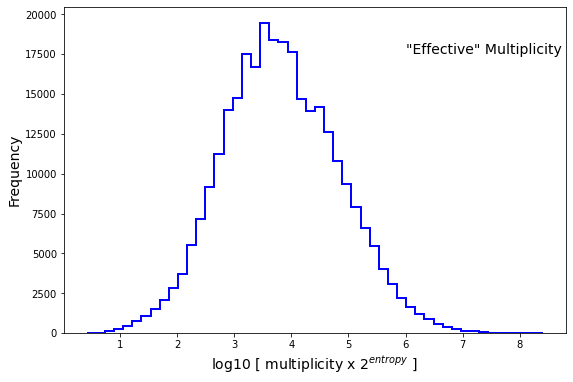

In [18]:
# make Figure 15
# (do Figure 14 first)
if WHICHDATA != "STUMS" :
    print("Figure 15 is now set up for STUMS only.")
else :
    plt.figure(figsize=(9, 6))
    xx = 2.**entropies_t.detach().cpu().numpy()
    yy = multiplicity[serials].detach().cpu().numpy().astype(float)
    plt.hist(np.log10(xx*yy), bins=50, alpha=0.99, lw=2., color='blue', histtype='step')
    plt.text(6.,17500.,'\"Effective\" Multiplicity',size=14)
    plt.xlabel('log10 [ multiplicity x $ 2^{entropy}$ ]',size=14)
    plt.ylabel('Frequency',size=14)
    plt.show()

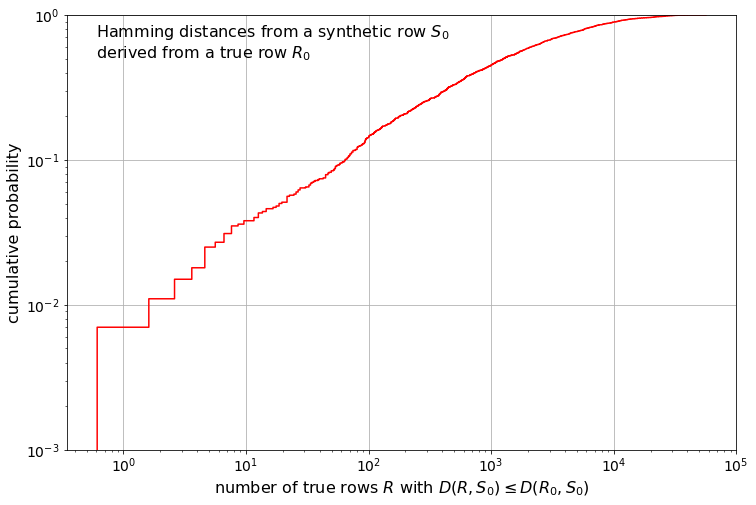

In [19]:
# make Figure 16
# assume in_bin_t and synthetic_t
plt.figure(figsize=(12, 8))
plt.text(0.6,0.5,"Hamming distances from a synthetic row $S_0$\nderived from a true row $R_0$",size=16)
plt.xlabel('number of true rows $R$ with $D(R,S_0) \leq D(R_0,S_0)$',size=16)
plt.ylabel('cumulative probability',size=16)
plt.grid(True)

ntry = 1000 # 10000 is better (takes 20 sec)
numcloser = []
nnum = 0
for itry in torch.arange(ntry) :
    jrow = torch.randint(in_bin_t.shape[0],(1,))
    alldists = torch.sum(synthetic_t != in_bin_t[jrow], axis=1)
    tsdist = alldists[jrow]
    alldists[jrow] = 17.5
    mask = (tsdist >= alldists).to(torch.float)
    num = torch.sum(mask).item()+1
    numcloser.append(num)
    if num == 1 : nnum += 1
numcloser = np.array(numcloser) + 0.01
numcloser = np.sort(numcloser)
cumprob = np.linspace(0.,1.,len(numcloser))
plt.step(numcloser-0.4,cumprob,lw=1.5,color='red')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1.e-3,1.))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

3 [113598  76676 102645]
5 [     0      0 107186 104142  81591]
12 [72859 33642 92979     0     0     0 91512     0  1291   636     0     0]


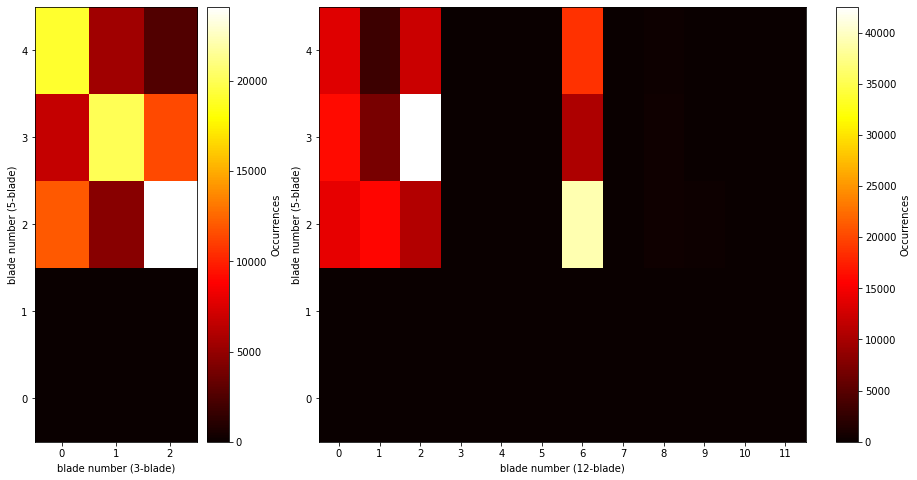

done.


In [20]:
# make Figure 12
if WHICHDATA != "STUMS" :
    print("Figure 12 is now set up for STUMS only.")
else :
    # This is a CUDA memory hog. If not enough memory, restart kernel and try running only first two cells, then this one.
    def bladeuse(model,inputs) :
        global spyweights
        model.eval()
        spyweights = []
        model_outputs = model(inputs)
        spyweights = spyweights[0].numpy()
        max_indices = np.argmax(spyweights, axis=1)
        counts = np.bincount(max_indices, minlength=spyweights.shape[1])
        print(model.num_blades,counts)
        myspy = spyweights.copy()
        return counts, myspy, max_indices

    torch.cuda.empty_cache() # try to release memory
    mode3 = load_model(dire + 'model_3_10.sav')[0].to(device)
    mode5 = load_model(dire + 'model_5_15.sav')[0].to(device)
    mode12 = load_model(dire + 'model_12_24.sav')[0].to(device)
    counts3, myspy3, max_indices3 = bladeuse(mode3,df_bin_t)
    counts5, myspy5, max_indices5 = bladeuse(mode5,df_bin_t)
    counts12, myspy12, max_indices12 = bladeuse(mode12,df_bin_t)

    Nn = len(df_bin_t)
    thresh = 0.9
    goodmask512 = ((myspy5[np.arange(Nn),max_indices5] > thresh) & (myspy12[np.arange(Nn),max_indices12] > thresh))
    goodmask35 = ((myspy3[np.arange(Nn),max_indices3] > thresh) & (myspy5[np.arange(Nn),max_indices5] > thresh))
    heatmap1, _, _ = np.histogram2d(max_indices5[goodmask35], max_indices3[goodmask35], bins=[6, 4], range=[[0,5], [0,3]])
    heatmap2, _, _ = np.histogram2d(max_indices5[goodmask512], max_indices12[goodmask512], bins=[6, 13], range=[[0,5], [0,12]])

    # Plotting the heatmap
    fig, (plt1,plt2) = plt.subplots(1, 2, figsize=(16, 8), width_ratios=[1, 3])

    im = plt1.imshow(heatmap1, origin='lower', cmap='hot', aspect='auto')
    cbar = fig.colorbar(im, ax=plt1)
    cbar.set_label('Occurrences')
    plt1.set_xticks(np.arange(6), labels=np.arange(6))
    plt1.set_yticks(np.arange(13), labels=np.arange(13))
    plt1.set_xlim((-.5,2.5))
    plt1.set_ylim((-.5,4.5))
    plt1.set_xlabel("blade number (3-blade)")
    plt1.set_ylabel("blade number (5-blade)")

    im = plt2.imshow(heatmap2, origin='lower', cmap='hot', aspect='auto')
    cbar = fig.colorbar(im, ax=plt2)
    cbar.set_label('Occurrences')
    plt2.set_yticks(np.arange(6), labels=np.arange(6))
    plt2.set_xticks(np.arange(13), labels=np.arange(13))
    plt2.set_xlim((-.5,11.5))
    plt2.set_ylim((-.5,4.5))
    plt2.set_xlabel("blade number (12-blade)")
    plt2.set_ylabel("blade number (5-blade)")
    plt.show()
    del mode12 # hint it should release memory
    torch.cuda.empty_cache() # try to release memory
    print('done.')